# STGCN

In [1]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from load_data import data_split, data_transform
from model import STGCN_WAVE
from sensors2graph import get_adjacency_matrix
from sklearn.preprocessing import StandardScaler
from utils import evaluate_model, evaluate_metric, args_func, device
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
args = args_func()

with open(args.sensorsfilepath) as f:
    sensor_ids = f.read().strip().split(",")

## 1. data prepare

### 1.1 Graph

In [3]:
print(f"file={args.disfilepath}")
distance_df = pd.read_csv(args.disfilepath, dtype={"from": "str", "to": "str"})
display(distance_df.head())
adj_mx = get_adjacency_matrix(distance_df, sensor_ids)
print('Adj Matrix:\n', adj_mx)

file=./data/sensor_graph/distances_la_2012.csv


,from,to,cost
0,1201054,1201054,0.0
1,1201054,1201066,2610.9
2,1201054,1201076,2822.7
3,1201054,1201087,2911.5
4,1201054,1201100,7160.1


Adj Matrix:
 [[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.3909554 ... 0.        0.        0.       ]
 [0.        0.7174379 1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        0.       ]
 [0.        0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 0.        0.        1.       ]]


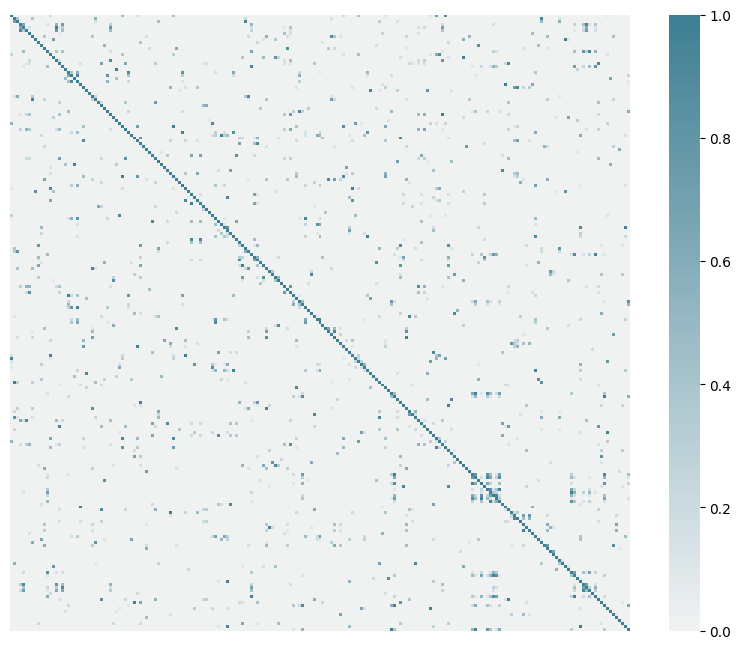

In [4]:

# plot 
mask = np.zeros_like(adj_mx, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(adj_mx, cmap=sns.diverging_palette(20, 220, n=200), center=0)
plt.xticks([])
plt.yticks([])
plt.show()

### 1.2 Time Series data

In [5]:
print(f"file={args.tsfilepath}")
df = pd.read_hdf(args.tsfilepath)
display(distance_df.head())
train, val, test = data_split(df, train_size=0.7, val_size=0.1)

file=./data/metr-la.h5


,from,to,cost
0,1201054,1201054,0.0
1,1201054,1201066,2610.9
2,1201054,1201076,2822.7
3,1201054,1201087,2911.5
4,1201054,1201100,7160.1


In [6]:
# data scale
scaler = StandardScaler()
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

### 1.3 Complete DataLoader

$$\hat{v_{t+1}},...,\hat{v_{t+H}}=\argmax_{v_{t+1},...,v_{t+H}} \text{ log P}(v_{t+1},...,v_{t+H}|v_{t-M+1},...,v_{t})$$

In [7]:
n_his = args.window
n_pred = args.pred_len
print(f"n_his={n_his}; n_pred={n_pred}")

x_train, y_train = data_transform(train, n_his, n_pred)
x_val, y_val = data_transform(val, n_his, n_pred)
x_test, y_test = data_transform(test, n_his, n_pred)
print(f"x_train.shape={x_train.shape}; y_train.shape={y_train.shape}")
# one sample: input 144 ts -> pred 5 ts
x_train[0].shape, y_train[0].shape

n_his=144; n_pred=5
device= cuda
device= cuda
device= cuda
x_train.shape=torch.Size([23841, 1, 144, 207]); y_train.shape=torch.Size([23841, 5, 207])


(torch.Size([1, 144, 207]), torch.Size([5, 207]))

In [8]:
# batch_size = args.batch_size
batch_size = 32
print(f"batch_size = {batch_size}")

train_data = TensorDataset(x_train, y_train)
train_iter = DataLoader(train_data, batch_size, shuffle=True)
val_data = TensorDataset(x_val, y_val)
val_iter = DataLoader(val_data, batch_size)
test_data = TensorDataset(x_test, y_test)
test_iter = DataLoader(test_data, batch_size)

batch_size = 32


## 2. Model

![](../pic/TCNBlock.png)

The <b><font color=darkred>residual connection</font></b> and <b><font color=darkred>bottleneck</font></b> strategy are applied inside each block

### 2.1 Temporal Gated-Conv


$$\Gamma _{*\tau} Y=P \odot \sigma(Q) \in \mathbb{R}^{C_o \times (M-k_t+1)  \times n}$$

- $f(Y) = [\text{P  Q}] \in \mathbb{R}^{2C_o \times (M-k_t+1) \times n }$
- $Y \in \mathbb{R}^{C_i \times M \times n }$
- M: his_n
- n: node_num
- $K_t$: kernal size
- $C_i$: Channel in size
- $C_o$: Channel out size

```python
# normal Conv2d channel-dim == 1
c = c_out // 2
out = conv(x)
# [batch, channel, his_n, node_num] 
P = out[:, :c, :, :]
Q = out[:, c:, :, :]
final_out = P * torch.sigmoid(Q)
```


In [9]:
class TCN(nn.Module):
    def __init__(self, c_in: int, c_out: int, dia: int=1):
        """TemporalConvLayer
        input_dim:  (batch_size, 1, his_time_seires_len, node_num)
        sample:     [b, 1, 144, 207]
        Args:
            c_in (int): channel in
            c_out (_type_): channel out
            dia (int, optional): The dilation size. Defaults to 1.
        """
        super(TCN, self).__init__()
        self.c_out = c_out * 2
        self.c_in = c_in
        self.conv = nn.Conv2d(
            c_in, self.c_out, (2, 1), 1, padding=(0, 0), dilation=dia
        )

    def forward(self, x):
        # [batch, channel, his_n, node_num] 
        #   kernel only filter on TimeSeries dim  his_n
        c = self.c_out//2
        out = self.conv(x)
        if len(x.shape) == 3: # channel, his_n, node_num
            P = out[:c, :, :]
            Q = out[c:, :, :]
        else:
            P = out[:, :c, :, :]
            Q = out[:, c:, :, :]
        return P * torch.sigmoid(Q)

In [10]:
a = torch.randn(size=(10, 1, 144, 207))
tcn = TCN(1, 3)
a.shape, tcn(a).shape

(torch.Size([10, 1, 144, 207]), torch.Size([10, 3, 143, 207]))

### 2.3 Graph CNNs for Extracting Spatial Features

$$out= \Theta_{* \mathcal{G}} x = \sum_{k=0}^{K-1}\theta_k T_k(\tilde{L})x=\sum_{k=0}^{K-1}W^{K, l}z^{k, l}$$
- $Z^{0, l} = H^{l}$
- $Z^{1, l} = \tilde{L} \cdot H^{l}$
- $Z^{k, l} = 2 \cdot \tilde{L} \cdot Z^{k-1, l} - Z^{k-2, l}$
- $\tilde{L} = 2\left(I - \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}\right)/\lambda_{max} - I$



In [11]:

class STCN_Cheb(nn.Module):
    def __init__(self, c, A, K=2):
        """spation cov layer
        Args:
            c (int): hidden dimension
            A (adj matrix): adj matrix
        """
        super(STCN_Cheb, self).__init__()
        self.K = K
        self.lambda_max = 2
        self.tilde_L = self.get_tilde_L(A)
        self.weight = nn.Parameter(torch.empty((K * c, c)))
        self.bias = nn.Parameter(torch.empty(c))
        stdv = 1.0 / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def get_tilde_L(self, A):
        I = torch.diag(torch.Tensor([1] * A.size(0))).float()
        tilde_A = A + I 
        tilde_D = torch.diag(torch.pow(tilde_A.sum(axis=1), -0.5))
        return 2 / self.lambda_max * (I - tilde_D @ tilde_A @ tilde_D) - I
    
    def forward(self, x):
        # For a signal with Ci channels M n C
        # [batch, channel, his_n, node_num] -> [batch, node_num, his_n, channel] -> [batch, his_n, node_num, channel] 
        x = x.transpose(1, 3)
        x = x.transpose(1, 2)
        output = self.m_unnlpp(x)
        output = output @ self.weight + self.bias
        # return dim
        output = output.transpose(1, 2)
        output = output.transpose(1, 3)
        return torch.relu(output) 
    
    def m_unnlpp(self, feat):
        K = self.K
        X_0 = feat
        Xt = [X_0]
        # X_1(f)
        if K > 1:
            X_1 = self.tilde_L @ X_0
            # Append X_1 to Xt
            Xt.append(X_1)

        for _ in range(2, K):
            X_i =  2 * self.tilde_L @ X_1 - X_0
            # Add X_1 to Xt
            Xt.append(X_i)
            X_1, X_0 = X_i, X_1
        # Create the concatenation
        Xt = torch.cat(Xt, dim=-1)
        return Xt


In [12]:
a = torch.randn(size=(10, 3, 144, 207))
A = torch.Tensor(adj_mx).float()
scn = STCN_Cheb(3, A, K=2)
a.shape, scn(a).shape

(torch.Size([10, 3, 144, 207]), torch.Size([10, 3, 144, 207]))

### 2.4 output Layer

1. Conv his_n -> 1
2. Channel features -> predict -> pred_n



In [13]:
class FullyConvLayer(nn.Module):
    def __init__(self, c, n):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, n, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n, pred_n):
        super(OutputLayer, self).__init__()
        # [batch, channel, his_n, node_num] conv his_n -> 1
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.fc = FullyConvLayer(c, pred_n)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2).squeeze(2)


### 2.5 final model 

detial : [model.py](./model.py)

In [14]:
blocks = [1, 64, 16, 64, 16, 64] # args.channels

# blocks = [1, 64, 16, 64, 16, 64]
# control_str = TNTSTNTST
#   TCN(1, 64*2)-> LayerNorm -> 
#   St-Conv Block1[  TCN(64, 16*2)->SCN(16, 16)->TCN(16, 64*2) ]  -> LayerNorm
#   St-Conv Block2[  TCN(64, 16*2)->SCN(16, 16)->TCN(16, 64*2) ]
n_route = x_train.shape[-1]
K = 2
num_layers = len(args.control_str)
print(f"""
blocks = {blocks}
n_route = {n_route}
K = {K}
num_layers = {num_layers}
control_str = {args.control_str}
""")

# move param and data to device
G = torch.Tensor(adj_mx).float()
G = G.to(device)
model = STGCN_WAVE(
    blocks, n_his, n_pred, n_route, G, K, device, args.control_str
).to(device)
model



blocks = [1, 64, 16, 64, 16, 64]
n_route = 207
K = 2
num_layers = 9
control_str = TNTSTNTST



STGCN_WAVE(
  (layers): ModuleList(
    (0): TCN(
      (conv): Conv2d(1, 128, kernel_size=(2, 1), stride=(1, 1))
    )
    (1): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (2): TCN(
      (conv): Conv2d(64, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(2, 2))
    )
    (3): STCN_Cheb()
    (4): TCN(
      (conv): Conv2d(16, 128, kernel_size=(2, 1), stride=(1, 1), dilation=(4, 4))
    )
    (5): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (6): TCN(
      (conv): Conv2d(64, 32, kernel_size=(2, 1), stride=(1, 1), dilation=(8, 8))
    )
    (7): STCN_Cheb()
    (8): TCN(
      (conv): Conv2d(16, 128, kernel_size=(2, 1), stride=(1, 1), dilation=(16, 16))
    )
  )
  (output): OutputLayer(
    (tconv1): Conv2d(64, 64, kernel_size=(113, 1), stride=(1, 1))
    (ln): LayerNorm((207, 64), eps=1e-05, elementwise_affine=True)
    (tconv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc): FullyConvLayer(
      (conv): Conv2d(64, 5, kernel_size=(1, 1)

## 3. Training

In [15]:
# optim scheduler
lr = args.lr
print(f"lr={lr}")
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# loss
loss = nn.MSELoss()

lr=0.001


In [16]:
save_path = args.savemodelpath
epochs = 10

min_val_loss = np.inf
for epoch in range(1, epochs + 1):
    l_sum, n = 0.0, 0
    model.train()
    tq_bar = tqdm(train_iter)
    tq_bar.set_description(f"[ Train | {epoch:03d} / {epochs:03d} ]")
    for x, y in tq_bar:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        l = loss(y_pred, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        l_sum += l.cpu().item() * y.shape[0]
        n += y.shape[0]
        tq_bar.set_postfix({'loss': "{:.5f}".format(l_sum / (n+0.0001))})

    scheduler.step()
    val_loss = evaluate_model(model, loss, val_iter)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
    print(f"epoch={epoch}, train loss:{l_sum / n:.5f}, validation loss:{val_loss:.5f}")


[ Train | 001 / 010 ]: 100%|██████████| 746/746 [02:25<00:00,  5.14it/s, loss=0.00425]


epoch=1, train loss:0.00425, validation loss:0.00041


[ Train | 002 / 010 ]: 100%|██████████| 746/746 [02:24<00:00,  5.16it/s, loss=0.00026]


epoch=2, train loss:0.00026, validation loss:0.00000


[ Train | 003 / 010 ]: 100%|██████████| 746/746 [02:24<00:00,  5.17it/s, loss=0.00005]


epoch=3, train loss:0.00005, validation loss:0.00000


[ Train | 004 / 010 ]: 100%|██████████| 746/746 [02:23<00:00,  5.19it/s, loss=0.00003]


epoch=4, train loss:0.00003, validation loss:0.00001


[ Train | 005 / 010 ]: 100%|██████████| 746/746 [02:23<00:00,  5.19it/s, loss=0.00002]


epoch=5, train loss:0.00002, validation loss:0.00000


[ Train | 006 / 010 ]: 100%|██████████| 746/746 [02:23<00:00,  5.18it/s, loss=0.00000]


epoch=6, train loss:0.00000, validation loss:0.00000


[ Train | 007 / 010 ]: 100%|██████████| 746/746 [02:24<00:00,  5.17it/s, loss=0.00001]


epoch=7, train loss:0.00001, validation loss:0.00000


[ Train | 008 / 010 ]: 100%|██████████| 746/746 [02:24<00:00,  5.17it/s, loss=0.00001]


epoch=8, train loss:0.00001, validation loss:0.00000


[ Train | 009 / 010 ]: 100%|██████████| 746/746 [02:23<00:00,  5.19it/s, loss=0.00000]


epoch=9, train loss:0.00000, validation loss:0.00000


[ Train | 010 / 010 ]: 100%|██████████| 746/746 [02:24<00:00,  5.18it/s, loss=0.00000]


epoch=10, train loss:0.00000, validation loss:0.00000


In [17]:
save_path = args.savemodelpath
best_model = STGCN_WAVE(
    blocks, n_his, n_pred, n_route, G, K, device, args.control_str
).to(device)
best_model.load_state_dict(torch.load(save_path, map_location='cpu'))
best_model.to(device)
l = evaluate_model(best_model, loss, test_iter)
MAE, MAPE, RMSE = evaluate_metric(best_model, test_iter, scaler)
print("test loss:", l, "\nMAE:", MAE, ", MAPE:", MAPE, ", RMSE:", RMSE)

100%|██████████| 210/210 [00:08<00:00, 25.23it/s]


test loss: 2.3424523439519626e-10 
MAE: 0.0042858931886271745 , MAPE: 7.998050592316799e-05 , RMSE: 0.005582154751522318
